# Organelle image classification

In [22]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from torchinfo import summary
from sklearn.metrics import precision_score, recall_score, f1_score

## 1. Introduction

This project aims to revolutionize protein classification through advanced image analysis techniques. The primary objective is to create a machine learning model capable of predicting the presence of specific proteins within a given image or multiple images, addressing the complexity of a multi-label classification challenge. The metric of choice for assessing model performance is the mean F1-score, ensuring precision and recall are both accounted for.

## 2. Loading the data

In [2]:
# load data
train_data_dir = "./train"
train_csv = "./train.csv"

test_data_dir = "./test"
test_csv = "./sub.csv"

In [3]:
# Load the csv file containing the train labels
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

In [4]:
# label dictionary
labels = {
    0: "Mitochondria",
    1: "Nuclear bodies",
    2: "Nucleoli",
    3: "Golgi apparatus",
    4: "Nucleoplasm",
    5: "Nucleoli fibrillar center",
    6: "Cytosol",
    7: "Plasma membrane",
    8: "Centrosome",
    9: "Nuclear speckles",
}

# 3. Data exploration

In [5]:
display(train_df.head())

,Image,Label
0,12874,1 4
1,21466,0
2,3610,4
3,2095,2 4
4,28909,4


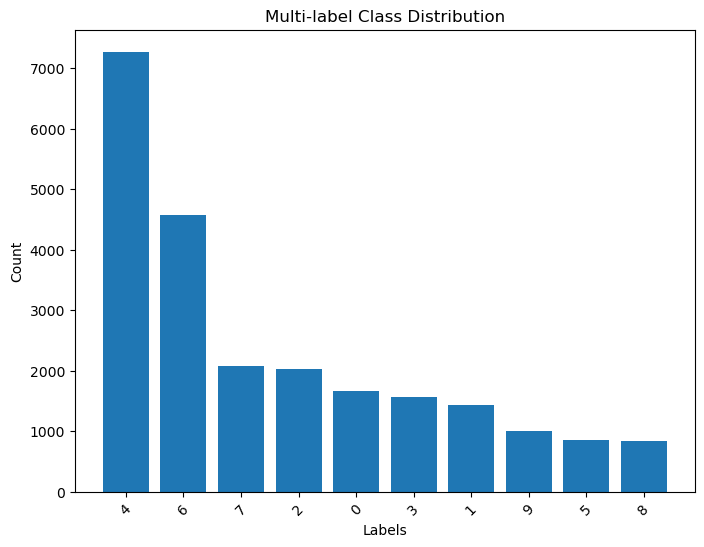

In [6]:
# Check class distribution

label_counts = {}
for labels in train_df['Label']:
    label_list = labels.split()
    for label in label_list:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1


sorted_label_counts = {k: v for k, v in sorted(label_counts.items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=(8, 6))
plt.bar(sorted_label_counts.keys(), sorted_label_counts.values())
plt.title('Multi-label Class Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


There is noticable class imbalance, 4 and 6 (Golgi apparatus, Nucleoplasm) have a much larger occurrence than the other classes.

Weights will be calculated and a weighted loss function will be used that assigns higher weights to minority class samples during training.

In [7]:
from sklearn.utils.class_weight import compute_class_weight

# Assuming 'train_df' contains your training dataset and 'Label' is the column name for the labels
class_labels = train_df['Label'].astype(str)  # Convert labels to strings

# Extract unique labels from the dataset
unique_labels = set()
for labels in class_labels:
    unique_labels.update(labels.split())

# Sort the unique labels to maintain a consistent order
unique_labels = sorted(list(unique_labels))

# Create a list of lists to hold labels for each sample
labels_per_sample = [label.split() for label in class_labels]

# Flatten the list of lists into a single list to calculate class weights
flat_labels = []
for labels in labels_per_sample:
    flat_labels.extend(labels)

# Calculate class weights based on occurrences
class_weights = compute_class_weight('balanced', classes=unique_labels, y=flat_labels)
weights_dict = {i:class_weights[i] for i in range(10)}
print("Class weights:", weights_dict)


Class weights: {0: 1.3986194477791116, 1: 1.6294405594405594, 2: 1.1506666666666667, 3: 1.4936538461538462, 4: 0.3203767358724048, 5: 2.7125727590221187, 6: 0.5094228246611281, 7: 1.1251086431675519, 8: 2.787200956937799, 9: 2.3139026812313803}


As we can see, more abundant classes 4 and 6 now carry lower weights.

In [8]:
# Explore image characteristics
sample_image = Image.open('./train/0.png')

print("Sample Image Information:")
print(f"Image Size: {sample_image.size}")
print(f"Image Mode: {sample_image.mode}")

Sample Image Information:
Image Size: (128, 128)
Image Mode: RGB


In [9]:
# Check for missing values in the dataset
missing_labels = train_df['Label'].isnull().sum()
print("Number of missing labels:", missing_labels)

Number of missing labels: 0


# 4. Preprocessing

In [10]:
# Since we have a multi-label classification problem, images can have more than 1 label. In order to transform the labels to a tensor that can be used for training, we can encode them to the format of a tensor, using a one-hot-encoding.
def encode_label(label: str):
    # create tensor of length 10 for the one-hot-ecoding
    target = torch.zeros(10)
    # now iterate over the classes in the string and set the respective 0's to 1's
    for l in str(label).split(" "):
        target[int(l)] = 1.0
    return target

In [11]:
# function to decode the encoded labels back to its original format


def decode_target(
    target: torch.Tensor, text_labels: bool = False, threshold: float = 0.5
):
    result = []
    for i, x in enumerate(target):
        if x >= threshold:
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return " ".join(result)

In [13]:
# To normalize the data we need to calculate the means and stdevs per channel for the images
# Initialize lists to store channel-wise mean and standard deviation
mean_per_channel = [0.0, 0.0, 0.0]
std_per_channel = [0.0, 0.0, 0.0]

# Iterate over all images in the dataset directory
count = 0
for filename in os.listdir(train_data_dir):
    img = Image.open(os.path.join(train_data_dir, filename))
    img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    
    # Calculate per-channel mean
    mean_per_channel[0] += np.mean(img[:, :, 0])
    mean_per_channel[1] += np.mean(img[:, :, 1])
    mean_per_channel[2] += np.mean(img[:, :, 2])
    
    # Calculate per-channel standard deviation
    std_per_channel[0] += np.std(img[:, :, 0])
    std_per_channel[1] += np.std(img[:, :, 1])
    std_per_channel[2] += np.std(img[:, :, 2])
    
    count += 1

# Calculate the mean and standard deviation across all images
total_images = len(os.listdir(train_data_dir))
mean_per_channel = [m / total_images for m in mean_per_channel]
std_per_channel = [s / total_images for s in std_per_channel]

print("Mean per channel:", mean_per_channel)
print("Standard deviation per channel:", std_per_channel)

Mean per channel: [0.07819786874680719, 0.05209000149719703, 0.05402339364832606]
Standard deviation per channel: [0.11591775167397261, 0.07654528936568694, 0.13421668103375917]


We are not dealing with everyday images but fluorescence microscopy. In these images, the RGB values behave different than regular. We will normalize the values based on the means and stdevs per channel.

# 5. Convolutional Neural Network

In [14]:
# We can create a PyTorchDataset that will ease the training process and can be used later for the DataLoader:


class ProteinDataset(Dataset):
    def __init__(self, dataframe, data_dir='./train', transform=None, mode='train'):
        self.data = dataframe
        self.transform = transform
        self.data_dir = data_dir
        self.mode = mode  # 'train' or 'test'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.mode == 'train':
            img_name = os.path.join(self.data_dir, str(self.data.iloc[idx, 0]) + '.png')
            image = Image.open(img_name)
            label = encode_label(self.data.iloc[idx, 1])

            if self.transform:
                image = self.transform(image)

            return image, label
        elif self.mode == 'test':
            img_name = os.path.join(self.data_dir, str(self.data.iloc[idx, 0]) + '.png')
            image = Image.open(img_name)

            if self.transform:
                image = self.transform(image)

            return image, self.data.iloc[idx, 0]  # Return image name for test mode
        else:
            raise ValueError("Invalid mode. Use 'train' or 'test'.")

In [15]:
class ProteinCNN(nn.Module):
    def __init__(self):
        super(ProteinCNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1
        )
        self.fc1 = nn.Linear(
            32 * 32 * 32, 256
        )
        self.fc2 = nn.Linear(
            256, 10
        )

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(
            -1, 32 * 32 * 32
        )
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
# Transformations
transforms_train = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128 pixels if still needed
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_per_channel, std=std_per_channel)
])


- Rotations and horizontal/vertical flips don't affect performance as these histology is not fixated in a certain orientation before imaging. All organelles are represented in a random rotation already.
- Cropping is unnecesary as the images are focused on the organelles of interest. There is no background noise to remove.
- 

In [17]:

train_size = int(0.8 * len(train_df))
val_size = len(train_df) - train_size

train_dataset, val_dataset = train_test_split(train_df, test_size=val_size)

train_loader = DataLoader(ProteinDataset(train_dataset, transform=transforms_train), batch_size=32, shuffle=True)
val_loader = DataLoader(ProteinDataset(val_dataset, transform=transforms_train), batch_size=32, shuffle=False)


In [18]:
model = ProteinCNN()

In [19]:
# Convert class_weights dictionary to a tensor
class_weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float)

criterion = nn.BCEWithLogitsLoss(weight=class_weights_tensor) # take into account the class_weights to battle the class imbalance
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels.float()).item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}")

print('Finished Training')

Epoch 1/10, Training Loss: 0.45402030077847566, Validation Loss: 0.4295280173267286
Epoch 2/10, Training Loss: 0.3987523685802113, Validation Loss: 0.4376473389949995
Epoch 3/10, Training Loss: 0.28332568461244756, Validation Loss: 0.49259686531479824
Epoch 4/10, Training Loss: 0.11809674561410756, Validation Loss: 0.7169362739803865
Epoch 5/10, Training Loss: 0.04198456878302159, Validation Loss: 1.023675912434293
Epoch 6/10, Training Loss: 0.020543378624194242, Validation Loss: 1.140686357144228
Epoch 7/10, Training Loss: 0.01450223003864869, Validation Loss: 1.2843260156739618
Epoch 8/10, Training Loss: 0.012611895419548375, Validation Loss: 1.4381994199507016
Epoch 9/10, Training Loss: 0.012138812985972731, Validation Loss: 1.4444149038226335
Epoch 10/10, Training Loss: 0.017792376396911485, Validation Loss: 1.4388187085230326
Finished Training


In [23]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
threshold = 0.5  # Define a threshold for prediction

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        
        # Apply threshold to convert probabilities to binary predictions
        predicted = (outputs > threshold).float()
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

        total += labels.size(0) * labels.size(1)  # Total number of elements in the batch
        correct += (predicted == labels).sum().item()  # Count correct predictions

accuracy = correct / total
print(f"Accuracy on validation set: {accuracy}")

# Calculate precision, recall, and F1-score for each label separately
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

# Print or use the calculated scores as needed
print("Precision for each label:", precision)
print("Recall for each label:", recall)
print("F1-score for each label:", f1)

Accuracy on validation set: 0.853183885640026
Precision for each label: [0.48447205 0.13207547 0.2892562  0.23529412 0.73029772 0.25581395
 0.53545586 0.44850498 0.18518519 0.23148148]
Recall for each label: [0.21910112 0.07835821 0.16786571 0.06514658 0.57716263 0.06790123
 0.40838852 0.32451923 0.12048193 0.12254902]
F1-score for each label: [0.30174081 0.09836066 0.2124431  0.10204082 0.64476227 0.10731707
 0.46336882 0.37656904 0.1459854  0.16025641]


In [24]:
# Predictions for the test set

test_dataset = ProteinDataset(test_df, data_dir=test_data_dir, transform=transforms_train, mode='test')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [25]:
# Make predictions for the test images
model.eval()
predictions = []

with torch.no_grad():
    for inputs, img_names in test_loader:
        outputs = model(inputs)
        
        # Apply threshold for binary predictions
        threshold = 0.5
        predicted = (outputs > threshold).squeeze().cpu().numpy().astype(int)
        
        # Convert predictions to label format
        predicted_labels = " ".join([str(i) for i in np.where(predicted == 1)[0]])

        # Append image names and predicted labels to list
        predictions.append((img_names[0].item(), predicted_labels))

# Write predictions to sub.csv
submission_df = pd.DataFrame(predictions, columns=["Image", "Label"])
submission_df.to_csv("sub.csv", index=False)